**This Notebook is partial implementation of the following research paper from Keras Website of Semantic Image Clustering** :-

https://arxiv.org/abs/2005.12320


The Notebook is application of Self-supervised representation learning
without the semantic part of the research paper.

*In The results displayed the elements in rows are the nearest neighbours of each other.*



In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from collections import defaultdict
import random, os, cv2
from PIL import Image
import numpy as np
import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt

     |████████████████████████████████| 686kB 9.5MB/s 


In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [4]:
IMG_DIR = '/gdrive/MyDrive/Colab Notebooks/detect_imgs_results'
images_li = []
for img in os.listdir(IMG_DIR):
    img_array = cv2.imread(os.path.join(IMG_DIR,img))
    new = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    images_li.append(new)

In [5]:
x_data = np.array(images_li)
x_data.shape

(12913, 160, 160, 3)

From KMeans Clustering Analysis, Using Elbow Rule :

 **1268 Clusters Were Found optimum**

Not Able to show here in graph because of RAM usage Limit.



Initialization of Variables

In [6]:
target_size = 160  
representation_dim = 512  
projection_units = 128
num_clusters = 1268  
k_neighbours = 7  
tune_encoder_during_clustering = False  

Data Preprocessing

In [7]:
data_preprocessing = keras.Sequential([layers.experimental.preprocessing.Resizing(target_size, target_size), layers.experimental.preprocessing.Normalization()])
data_preprocessing.layers[-1].adapt(x_data)

Augmentation

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomTranslation(
            height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode="nearest"
        ),
        layers.experimental.preprocessing.RandomFlip(mode="horizontal"),
        layers.experimental.preprocessing.RandomRotation(
            factor=0.15, fill_mode="nearest"
        ),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=(-0.3, 0.1), width_factor=(-0.3, 0.1), fill_mode="nearest"
        )
    ]
)

In [9]:
def create_encoder(representation_dim):
    encoder = keras.Sequential(
        [
            keras.applications.ResNet50V2(
                include_top=False, weights=None, pooling="avg"
            ),
            layers.Dense(representation_dim),
        ]
    )
    return encoder

In [13]:
class RepresentationLearner(keras.Model):
    def __init__(
        self,
        encoder,
        projection_units,
        num_augmentations,
        temperature=1.0,
        dropout_rate=0.1,
        l2_normalize=False,
        **kwargs
    ):
        super(RepresentationLearner, self).__init__(**kwargs)
        self.encoder = encoder
        self.projector = keras.Sequential(
            [
                layers.Dropout(dropout_rate),
                layers.Dense(units=projection_units, use_bias=False),
                layers.BatchNormalization(),
                layers.ReLU(),
            ]
        )
        self.num_augmentations = num_augmentations
        self.temperature = temperature
        self.l2_normalize = l2_normalize
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def compute_contrastive_loss(self, feature_vectors, batch_size):
        num_augmentations = tf.shape(feature_vectors)[0] // batch_size
        if self.l2_normalize:
            feature_vectors = tf.math.l2_normalize(feature_vectors, -1)
        logits = (
            tf.linalg.matmul(feature_vectors, feature_vectors, transpose_b=True)
            / self.temperature
        )
        logits_max = tf.math.reduce_max(logits, axis=1)
        logits = logits - logits_max
        targets = tf.tile(tf.eye(batch_size), [num_augmentations, num_augmentations])
        return keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )

    def call(self, inputs):
        preprocessed = data_preprocessing(inputs)
        augmented = []
        for _ in range(self.num_augmentations):
            augmented.append(data_augmentation(preprocessed))
        augmented = layers.Concatenate(axis=0)(augmented)
        features = self.encoder(augmented)
        return self.projector(features)

    def train_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        with tf.GradientTape() as tape:
            feature_vectors = self(inputs, training=True)
            loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_tracker.update_state(loss)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        feature_vectors = self(inputs, training=False)
        loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [14]:
encoder = create_encoder(representation_dim)
representation_learner = RepresentationLearner(
    encoder, projection_units, num_augmentations=2, temperature=0.1
)
lr_scheduler = keras.experimental.CosineDecay(
    initial_learning_rate=0.001, decay_steps=500, alpha=0.1
)
representation_learner.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=lr_scheduler, weight_decay=0.0001),
)
history = representation_learner.fit(
    x=x_data,
    batch_size=32,
    epochs=20, 
)

Epoch 1/20
404/404 [==============================] - 183s 351ms/step - loss: 78.5521
Epoch 2/20
404/404 [==============================] - 143s 353ms/step - loss: 30.8254
Epoch 3/20
404/404 [==============================] - 142s 352ms/step - loss: 18.0799
Epoch 4/20
404/404 [==============================] - 143s 353ms/step - loss: 10.5006
Epoch 5/20
404/404 [==============================] - 142s 352ms/step - loss: 7.3725
Epoch 6/20
404/404 [==============================] - 142s 352ms/step - loss: 5.6054
Epoch 7/20
404/404 [==============================] - 143s 353ms/step - loss: 4.7943
Epoch 8/20
404/404 [==============================] - 142s 352ms/step - loss: 4.0069
Epoch 9/20
404/404 [==============================] - 143s 353ms/step - loss: 3.6813
Epoch 10/20
404/404 [==============================] - 143s 353ms/step - loss: 3.4786
Epoch 11/20
404/404 [==============================] - 142s 352ms/step - loss: 3.2144
Epoch 12/20
404/404 [==============================] - 143s

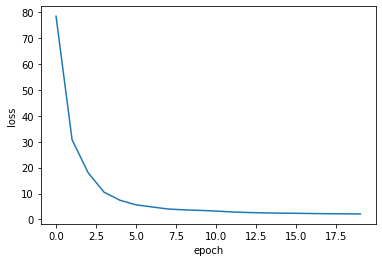

In [15]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

# Nearest Neighbour

In [16]:
batch_size = 32
feature_vectors = encoder.predict(x_data, batch_size=batch_size, verbose=1)
feature_vectors = tf.math.l2_normalize(feature_vectors, -1)

404/404 [==============================] - 25s 57ms/step


In [17]:
neighbours = []
num_batches = feature_vectors.shape[0] // batch_size
for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    current_batch = feature_vectors[start_idx:end_idx]
    similarities = tf.linalg.matmul(current_batch, feature_vectors, transpose_b=True)
    _, indices = tf.math.top_k(similarities, k=k_neighbours + 1, sorted=True)
    neighbours.append(indices[..., 1:])

neighbours = np.reshape(np.array(neighbours), (-1, k_neighbours))

100%|██████████| 403/403 [00:00<00:00, 1069.49it/s]


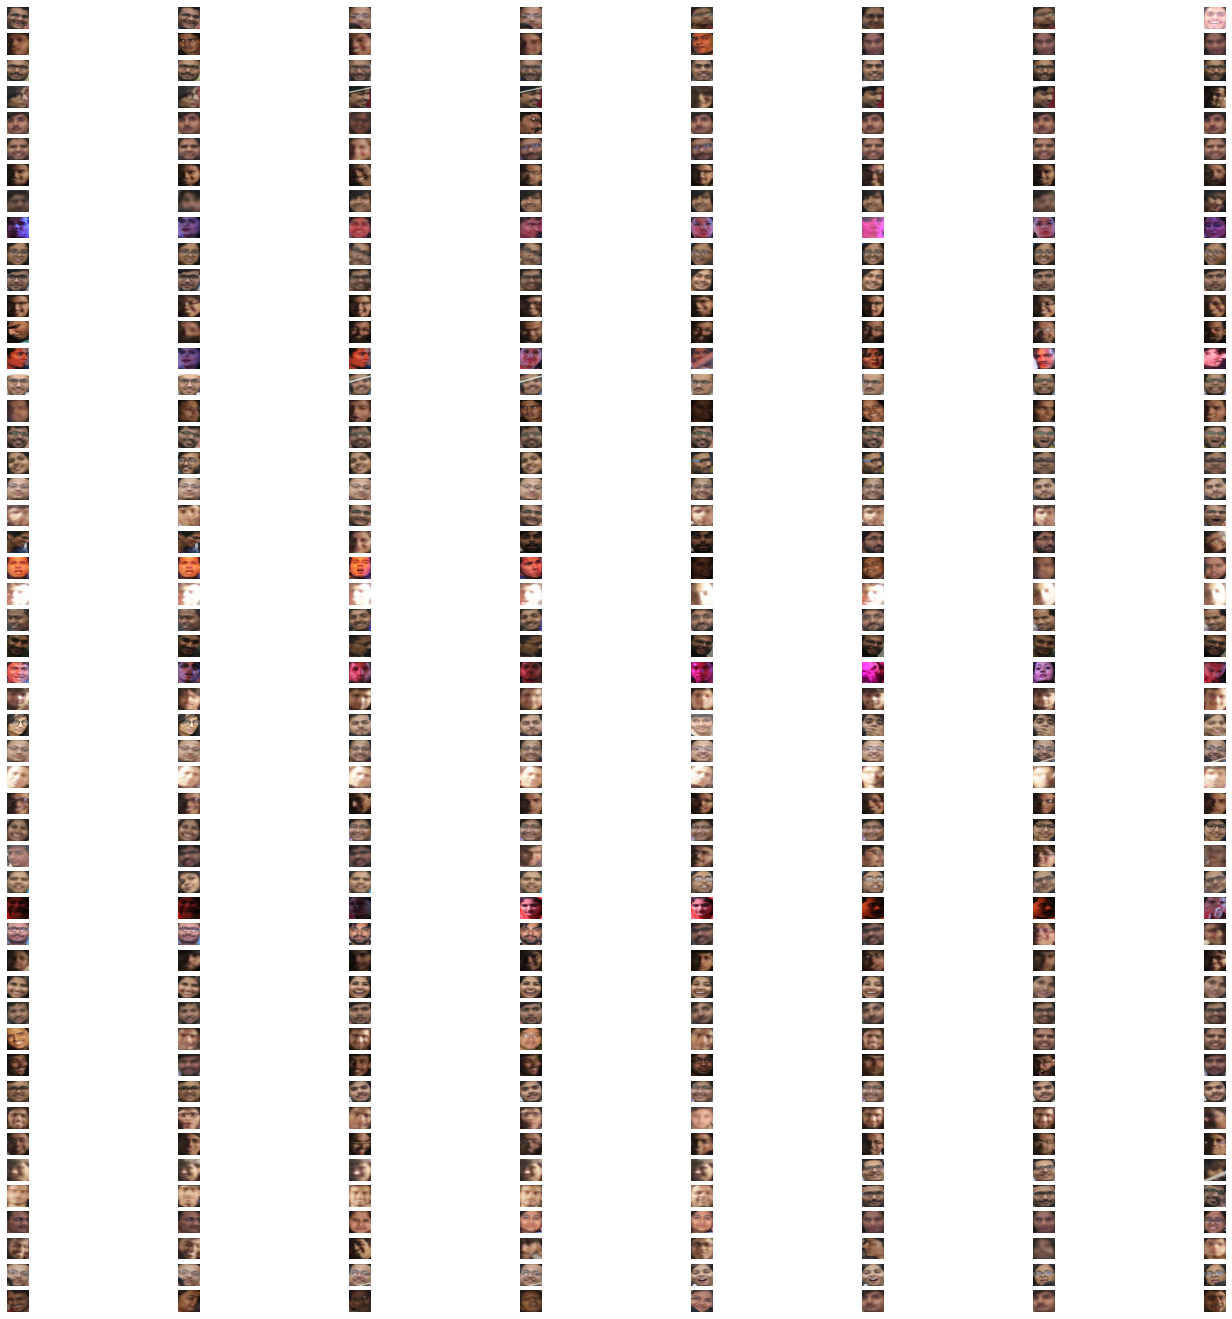

In [26]:
nrows = 50
ncols = k_neighbours + 1

plt.figure(figsize=(24, 24))
position = 1
for _ in range(nrows):
    anchor_idx = np.random.choice(range(x_data.shape[0]))
    neighbour_indicies = neighbours[anchor_idx]
    indices = [anchor_idx] + neighbour_indicies.tolist()
    for j in range(ncols):
        plt.subplot(nrows, ncols, position)
        plt.imshow(x_data[indices[j]].astype("uint8"))
        plt.axis("off")
        position += 1
